# C4 Detection Training Data

This file generates the training data for the C4 detection project led by Dr. Wenli Huang. You need two things to generate the training data:

* 8 images per sample, one image for each of the 8 wavelengths
* A mask for the images. The mask separates the explosive chemical from the background material. The mask should be saved as `mask.j2` in the sample folder. 

This notebook builds vectors from each cooresponding vector in the images and labels each one based on the mask. The output is a numpy array with 8 columns, each column corresponding to the intensity of one of the 8 wavelengths for that pixel. 

# Masks

There are two mask files for each sample. The first, which we call the **signal mask**, is perfectly white (in a `Gray` profile, the pixel value is `255`) if that pixel is explosive material. The second mask is the background mask. Those pixels are white if the pixel is background and not explosive material. Not every pixel falls into one of the masks.

We are currently using [GIMP](www.gimp.org) to build the masks. Ideally we'd have too many samples to manually build masks, so you could imagine using [computer vision](https://docs.opencv.org/3.3.1/d4/d73/tutorial_py_contours_begin.html) to do it programmatically. 

# Packages

Here are the packages you'll need to run this notebook. Note versions of `Pillow` before 6.0.0 threw EXIF errors for our samples. 

In [3]:
import os
import glob
import pickle
import numpy as np
from skimage import io as skio

## Generate vectors

These are the unix globs for the each sample. Each glob should return exactly 8 images. Just run this notebook every time you add or modify a sample. If you are looking to rebuild the training for a particular sample, just comment out the others. 

In [6]:
SAMPLE_PATHS = [
    "C4 black car panel/F*-1.png",
    "C4 metal panel/F*-1.png",
    "C4 red glossy paper/F*-1.png",
    "C4 white car panel/F*-1.png",
    "C4 wood panel/F*-1.png",
    "DSYP60-not-C4/F*-1.png",
    "50ug-SamariumNitrate-Not-C4/F*-1.png",
    "C4 chunk/F*-1.png",
]

Read images, build vectors, read mask, append labels. The vector are saved as serialized numpy arrays to their respective sample folders. 

When it's finished, each sample directory will contains a `training.p` file (the `p` is for "pickle", Python's serialization format). We'll use those in the training notebooks. 

In [7]:
for sample in SAMPLE_PATHS:
    images = []
    dirname = os.path.dirname(sample)
    print("Processing", dirname, "...")
    
    for filename in sorted(glob.glob(sample)):
        images.append(skio.imread(filename))

    for mask in ["background mask.png", "signal mask.png"]:
        print("\tProcessing", mask, "...")
        pixels = skio.imread(os.path.join(dirname,mask))
        images.append(pixels == 255)

    vectors = np.stack(images,axis=-1).reshape(-1,len(images))
    
    # filter out everything that isn't labeled as signal or background
    vectors = vectors[np.logical_or(vectors[:,-1],vectors[:,-2])]

    # the labels are the last columns
    labels = vectors[:,-1]
    
    # we no longer need the mask columns
    training = vectors[:,:-2]
    
    path = os.path.join(dirname, "training.p")
    pickle.dump((training,labels), open(path, "wb"))

Processing C4 black car panel ...
	Processing background mask.png ...
	Processing signal mask.png ...
Processing C4 metal panel ...
	Processing background mask.png ...
	Processing signal mask.png ...
Processing C4 red glossy paper ...
	Processing background mask.png ...
	Processing signal mask.png ...
Processing C4 white car panel ...
	Processing background mask.png ...
	Processing signal mask.png ...
Processing C4 wood panel ...
	Processing background mask.png ...
	Processing signal mask.png ...
Processing DSYP60-not-C4 ...
	Processing background mask.png ...
	Processing signal mask.png ...
Processing 50ug-SamariumNitrate-Not-C4 ...
	Processing background mask.png ...
	Processing signal mask.png ...
Processing C4 chunk ...
	Processing background mask.png ...
	Processing signal mask.png ...


## Visualizing masks

If you want to highlight certain pixels, you build a mask and overlay that on your image. Here's an example of doing that.

In [13]:
from skimage import data
from matplotlib import pyplot as plt

Grab an image.

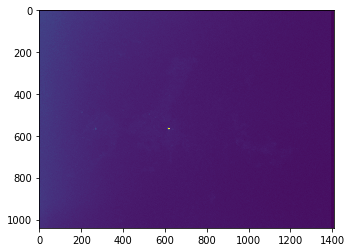

In [14]:
filename = sorted(glob.glob(SAMPLE_PATHS[0]))[0]
image = skimage.io.imread(filename)
plt.imshow(image)

Create a mask. You need a numpy array the same shape as your image. I will build a mask using one of the mask files. 

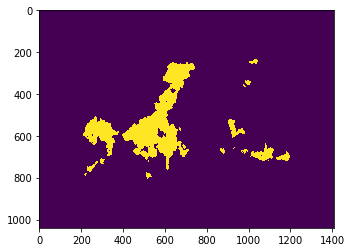

In [15]:
dirname = os.path.dirname(filename)
mask_filename = os.path.join(dirname,"signal mask.png")
mask_image = io.imread(mask_filename)
plt.imshow(mask_image)

The actual mask is a boolean value corresponding to every pixel in the original image. Let's just create a mask where every pixel in the mask file is zero. 

In [17]:
mask = mask_image == 255
mask

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

Now apply the mask to the original image. We'll make the mask overlay green. That means we'll need to convert the grayscale image to RGB.

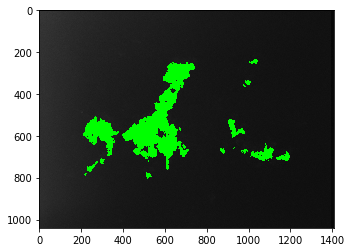

In [18]:
color = skimage.color.gray2rgb(image)
color[mask] = (0,255,0)
plt.imshow(color)